<a href="https://colab.research.google.com/github/MeredithClikkie/MeredithClikkie/blob/main/nb/chap09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

(chapter_hypothesis_testing)=
# Hypothesis Testing

In the datasets we have explored in this book, we've seen differences between groups of people -- and penguins -- correlations between variables, and slopes of regression lines.
Results like these are called **observed effects** because they appear in a sample, as contrasted with actual effects in the population, which we usually can't observe directly.
When we see an apparent effect, we should consider whether it is likely to be present in the larger population or whether it might appear in the sample by chance.

There are several ways to formulate this question, including Fisher null hypothesis testing, Neyman-Pearson decision theory, and Bayesian hypothesis testing.
What I present here is a mixture of these approaches that is often used in practice.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap09.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Flipping Coins

We'll start with a simple example, based on an example in David MacKay's book, *Information Theory, Inference, and Learning Algorithms*.

When Euro coins were introduced in 2002, a curious coin enthusiast spun a Belgian one-Euro coin on edge 250 times and noted that it landed with the heads side up 140 times and tails side up 110 times.
If the coin is perfectly balanced, we expect only 125 heads, so this data suggests the coin is biased.
On the other hand, we don't expect to get exactly 125 heads every time, so it's possible that the coin is actually fair, and the apparent deviation from the expected value is due to chance.
To see whether that's plausible, we can perform a hypothesis test.

We'll use the following function to compute the absolute difference between the observed number and the expected number if the coin is fair.

In [4]:
n = 250
p = 0.5


def abs_deviation(heads):
    expected = n * p
    return np.abs(heads - expected)

In the observed data, this deviation is 15.

In [5]:
heads = 140
tails = 110

observed_stat = abs_deviation(heads)
observed_stat

np.float64(15.0)

If the coin is actually fair, we can simulate the coin-spinning experiment by generating a sequence of random strings -- either `'H'` or `'T'` with equal probability -- and counting the number of times `'H'` appears.

In [6]:
def simulate_flips():
    flips = np.random.choice(["H", "T"], size=n)
    heads = np.sum(flips == "H")
    return heads

Each time we call this function, we get the outcome of a simulated experiment.

In [7]:
np.random.seed(1)

In [8]:
simulate_flips()

np.int64(119)

The following loop simulates the experiment many times, computes the deviation for each one, and uses a list comprehension to collect the results in a list.

In [9]:
simulated_stats = [abs_deviation(simulate_flips()) for i in range(10001)]

The result is a sample from the distribution of deviations under the assumption that the coin is fair.
Here's what the distribution of these values looks like.

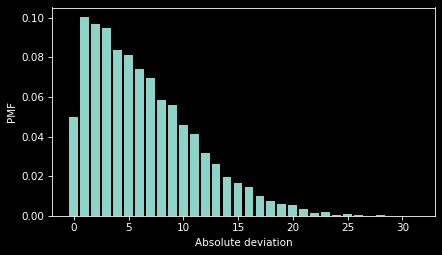

In [10]:
from empiricaldist import Pmf

pmf_effects = Pmf.from_seq(simulated_stats)
pmf_effects.bar()

decorate(xlabel="Absolute deviation", ylabel="PMF")

Values near 0 are the most common; values greater than 10 are less common.
Remembering that the deviation in the observed data is 15, we see that deviations of that magnitude are rare, but not impossible.
In this example, the simulated results equal or exceed 15 about 7.1% of the time.

In [11]:
(np.array(simulated_stats) >= 15).mean() * 100

np.float64(7.079292070792921)

So, if the coin is fair, we expect a deviation as big as the one we saw about 7.1% of the time, just by chance.

We can conclude that an effect of this size is not common, but it is certainly not impossible, even if the coin is fair.
On the basis of this experiment, we can't rule out the possibility that the coin is fair.

This example demonstrates the logic of statistical hypothesis testing.

* We started with an observation, 140 heads out of 250 spins, and the hypothesis that the coin is biased -- that is, that the probability of heads differs from 50%.

* We chose a **test statistic** that quantifies the size of the observed effect. In this example, the test statistic is the absolute deviation from the expected outcome.

* We defined a **null hypothesis**, which is a model based on the assumption that the observed effect is due to chance. In this example, the null hypothesis is that the coin is fair.

* Next, we computed a **p-value**, which is the probability of seeing the observed effect if the null hypothesis is true. In this example, the p-value is the probability of a deviation as big as 15 or bigger.

The last step is to interpret the result.
If the p-value is small, we conclude that the effect would be unlikely to happen by chance.
If it is large, we conclude that the effect could plausibly be explained by chance.
And if it falls somewhere in the middle, as in this example, we can say that the effect is unlikely to happen by chance, but we can't rule out the possibility.

All hypothesis tests are based on these elements -- a test statistic, a null hypothesis, and a p-value.

(section_diff_means)=
## Testing a Difference in Means

In the NSFG data, we saw that the average pregnancy length for first babies is slightly longer than for other babies.
Now let's see if that difference could be due to chance.

The following cells download the data and install `statadict`, which we need to read the data.

In [12]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

In [13]:
try:
    import statadict
except ImportError:
    %pip install statadict

The function `get_nsfg_groups` reads the data, selects live births, and groups live births into first babies and others.

In [14]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

Now we can select pregnancy lengths, in weeks, for both groups.

In [15]:
data = firsts["prglngth"].values, others["prglngth"].values

The following function takes the data as a tuple of two sequences, and computes the absolute difference in means.

In [16]:
def abs_diff_means(data):
    group1, group2 = data
    diff = np.mean(group1) - np.mean(group2)
    return np.abs(diff)

Between first babies and others, the observed difference in pregnancy length is 0.078 weeks.

In [17]:
observed_diff = abs_diff_means(data)
observed_diff

np.float64(0.07803726677754952)

So the hypothesis we'll test is whether pregnancy length is generally longer for first babies.
The null hypothesis is that pregnancy lengths are actually the same for both groups, and the apparent difference is due to chance.
If pregnancy lengths are the same for both groups, we can combine the two groups into a single pool.
To simulate the experiment, we can use the NumPy function `shuffle` to put the pooled values in random order, and then use slice indexes to select two groups with the same sizes as the original.

In [18]:
def simulate_groups(data):
    group1, group2 = data
    n, m = len(group1), len(group2)

    pool = np.hstack(data)
    np.random.shuffle(pool)
    return pool[:n], pool[-m:]

Each time we call this function, it returns a tuple of sequences, which we can pass to `abs_diff_means`.

In [19]:
abs_diff_means(simulate_groups(data))

np.float64(0.031193045602279312)

The following loop simulates the experiment many times and computes the difference in means for each simulated dataset.

In [20]:
simulated_diffs = [abs_diff_means(simulate_groups(data)) for i in range(1001)]

To visualize the results, we'll use the following function, which takes a sample of simulated results and makes a `Pmf` object that approximates its distribution.

In [21]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf


def make_pmf(sample, low, high):
    kde = gaussian_kde(sample)
    qs = np.linspace(low, high, 201)
    ps = kde(qs)
    return Pmf(ps, qs)

We'll also use this function, which fills in the tail of the distribution.

In [22]:
from thinkstats import underride


def fill_tail(pmf, observed, side, **options):
    """Fill the area under a PMF, right or left of an observed value."""
    options = underride(options, alpha=0.3)

    if side == "right":
        condition = pmf.qs >= observed
    elif side == "left":
        condition = pmf.qs <= observed

    series = pmf[condition]
    plt.fill_between(series.index, 0, series, **options)

Here's what the distribution of the simulated results looks like.
The shaded region shows the cases where the difference in means under the null hypothesis exceeds the observed difference.
The area of this region is the p-value.

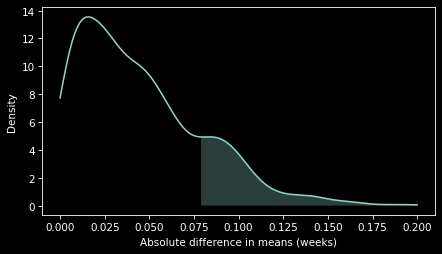

In [23]:
pmf = make_pmf(simulated_diffs, 0, 0.2)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in means (weeks)", ylabel="Density")

The following function computes the p-value, which is the fraction of simulated values that are as big or bigger than the observed value.

In [24]:
def compute_p_value(simulated, observed):
    """Fraction of simulated values as big or bigger than the observed value."""
    return (np.asarray(simulated) >= observed).mean()

In this example, the p-value is about 18%, which means it is plausible that a difference as big as 0.078 weeks could happen by chance.

In [25]:
compute_p_value(simulated_diffs, observed_diff)

np.float64(0.1838161838161838)

Based on this result, we can't be sure that pregnancy lengths are generally longer for first babies -- it's possible that the difference in this dataset is due to chance.

Notice that we've seen the same elements in both examples of hypothesis testing: a test statistic, a null hypothesis, and a model of the null hypothesis.
In this example, the test statistic is the absolute difference in the means.
The null hypothesis is that the distribution of pregnancy lengths is actually the same in both groups.
And we modeled the null hypothesis by combining the data from both groups into a single pool, shuffling the pool, and splitting it into two groups with the same sizes as the originals.
This process is called **permutation**, which is another word for shuffling.

This computational approach to hypothesis testing makes it easy to combine these elements to test different statistics.

## Other Test Statistics

We might wonder whether pregnancy lengths for first babies are not just longer, but maybe more variable.
To test that hypothesis, we can use as a test statistic the absolute difference between the standard deviations of the two groups.
The following function computes this test statistic.

In [26]:
def abs_diff_stds(data):
    group1, group2 = data
    diff = np.std(group1) - np.std(group2)
    return np.abs(diff)

In the NSFG dataset, the difference in standard deviations is about 0.18.

In [27]:
observed_diff = abs_diff_stds(data)
observed_diff

np.float64(0.17600895913991677)

To see whether this difference might be due to chance, we can use permutation again.
The following loop simulates the null hypothesis many times and computes the difference in standard deviation for each simulated dataset.

In [28]:
simulated_diffs = [abs_diff_stds(simulate_groups(data)) for i in range(1001)]

Here's what the distribution of the results looks like.
Again, the shaded region shows where the test statistic under the null hypothesis exceeds the observed difference.

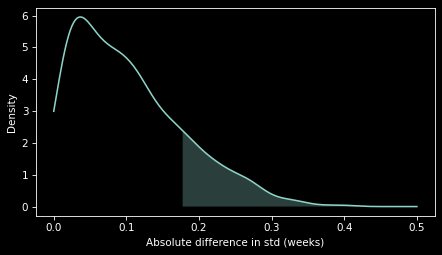

In [29]:
pmf = make_pmf(simulated_diffs, 0, 0.5)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in std (weeks)", ylabel="Density")

We can estimate the area of this region by computing the fraction of results that are as big or bigger than the observed difference.

In [30]:
compute_p_value(simulated_diffs, observed_diff)

np.float64(0.17082917082917082)

The p-value is about 0.17, so it is plausible that we could see a difference this big even if the two groups are the same.
In conclusion, we can't be sure that pregnancy lengths are generally more variable for first babies -- the difference we see in this dataset could be due to chance.

(section_test_correlation)=
## Testing a Correlation

We can use the same framework to test correlations.
For example, in the NSFG data set, there is a correlation between birth weight and mother's age -- older mothers have heavier babies, on average.
But could this effect be due to chance?

To find out, we'll start by preparing the data.
From live births, we'll select cases where the age of the mother and birth weight are known.

In [31]:
valid = live.dropna(subset=["agepreg", "totalwgt_lb"])
valid.shape

(9038, 244)

Then we'll select the relevant columns.

In [32]:
ages = valid["agepreg"]
birthweights = valid["totalwgt_lb"]

The following function takes a tuple of `xs` and `ys` and computes the magnitude of the correlation, positive or negative.

In [33]:
def abs_correlation(data):
    xs, ys = data
    corr = np.corrcoef(xs, ys)[0, 1]
    return np.abs(corr)

In the NSFG dataset, the correlation is about 0.07.

In [34]:
data = ages, birthweights
observed_corr = abs_correlation(data)
observed_corr

np.float64(0.06883397035410906)

The null hypothesis is that there is no correlation between mother's age and birth weight.
By shuffling the observed values, we can simulate a world where the distributions of age and birth weight are the same, but where the variables are unrelated.

The following function takes a tuple of `xs` and `ys`, shuffles `xs` and returns a tuple containing the shuffled `xs` and the original `ys`.
It would also work if we shuffled the `ys` instead, or shuffled both.

In [35]:
def permute(data):
    xs, ys = data
    new_xs = xs.values.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

The correlation of the shuffled values is usually close to 0.

In [36]:
abs_correlation(permute(data))

np.float64(0.0019269515502894341)

The following loop generates many shuffled datasets and computes the correlation of each one.

In [37]:
simulated_corrs = [abs_correlation(permute(data)) for i in range(1001)]

Here's what the distribution of the results looks like.
The vertical dotted line shows the observed correlation.

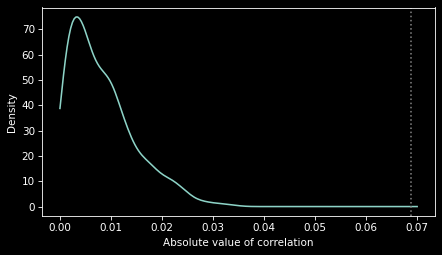

In [38]:
pmf = make_pmf(simulated_corrs, 0, 0.07)
pmf.plot()
plt.axvline(observed_corr, color="gray", ls=":")
decorate(xlabel="Absolute value of correlation", ylabel="Density")

We can see that the observed correlation is in the tail of the distribution, with no visible area under the curve.
If we try to compute a p-value, the result is 0, indicating that the correlation in the shuffled data did not exceed the observed value in any of the simulations.

In [39]:
compute_p_value(simulated_corrs, observed_corr)

np.float64(0.0)

Based on this calculation, we can conclude that the p-value is probably less that 1 per 1000, but it is not actually zero.
It is unlikely for the correlation of the shuffled data to exceed the observed value -- but it is not impossible.

When the p-value is small, traditionally less than 0.05, we can say that the result is **statistically significant**.
But this way of interpreting p-values has always been problematic, and it is slowly becoming less widely used.

One problem is that the traditional threshold is arbitrary and not appropriate for all applications.
Another problem is that this use of "significant" is misleading because it suggests that the effect is important in practice.
The correlation between mother's age and birth weight is a good example -- it is statistically significant, but so small that it is not important.

An alternative is to interpret p-values qualitatively.

* If a p-value is large, it is plausible that the observed effect could happen by chance.

* If the p-value is small, we can often rule out the possibility that the effect is due to chance -- but we should remember that it could still be due to non-representative sampling or measurement errors.

(section_testing_proportions)=
## Testing Proportions

As a final example, let's consider a case where the choice of the test statistic takes some thought.
Suppose you run a casino and you suspect that a customer is using a crooked die -- that is, one that has been modified to make one of the faces more likely than the others.
You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.
You roll the die 60 times and record the frequency of each outcome from 1 to 6.
Here are the results in a `Hist` object.

In [40]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

,freqs
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


On average you expect each value to appear 10 times.
In this dataset, the value 3 appears more often than expected, and the value 4 appears less often.
But could these differences happen by chance?

To test this hypothesis, we'll start by computing the expected frequency for each outcome.

In [41]:
num_rolls = observed.sum()
outcomes = observed.qs
expected = Hist(num_rolls / 6, outcomes)

The following function takes the observed and expected frequencies and computes the sum of the absolute differences.

In [42]:
def total_abs_deviation(observed):
    return np.sum(np.abs(observed - expected))

In the observed dataset, this test statistic is 20.

In [43]:
observed_dev = total_abs_deviation(observed)
observed_dev

np.float64(20.0)

The following function takes the observed data, simulates rolling a fair die the same number of times, and returns a `Hist` object that contains the simulated frequencies.

In [44]:
def simulate_dice(observed):
    num_rolls = np.sum(observed)
    rolls = np.random.choice(observed.qs, num_rolls, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

The following loop simulates the experiment many times and computes the total absolute deviation for each one.

In [45]:
simulated_devs = [total_abs_deviation(simulate_dice(observed)) for i in range(1001)]

Here's what the distribution of the test statistic looks like under the null hypothesis.
Notice that the total is always even, because every time an outcome appears more often than expected, another outcome has to appear less often.

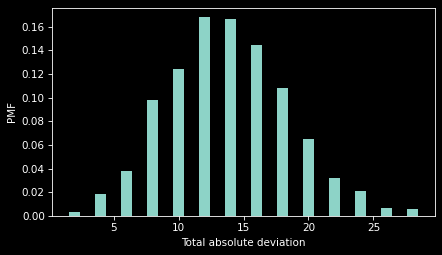

In [46]:
pmf_devs = Pmf.from_seq(simulated_devs)
pmf_devs.bar()

decorate(xlabel="Total absolute deviation", ylabel="PMF")

We can see that a total deviation of 20 is not unusual -- the p-value is about 13%, which means that we can't be sure the die is crooked.

In [47]:
compute_p_value(simulated_devs, observed_dev)

np.float64(0.13086913086913088)

But the test statistic we chose was not the only option.
For a problem like this, it would be more conventional to use the chi-squared statistic, which we can compute like this.

In [48]:
def chi_squared_stat(observed):
    diffs = (observed - expected) ** 2
    return np.sum(diffs / expected)

Squaring the deviations (rather than taking absolute values) gives more weight to large deviations.
Dividing through by `expected` standardizes the deviations -- although in this case it has no effect on the results because the expected frequencies are all equal.

In [49]:
observed_chi2 = chi_squared_stat(observed)
observed_chi2

np.float64(11.6)

The chi-squared statistic of the observed data is 11.6.
By itself, this number doesn't mean very much, but we can compare it to the results from the simulated rolls.
The following loop generates many simulated datasets and computes the chi-squared statistic for each one.

In [50]:
simulated_chi2 = [chi_squared_stat(simulate_dice(observed)) for i in range(1001)]

Here's what the distribution of this test statistic looks like under the null hypothesis.
The shaded region shows the results that exceed the observed value.

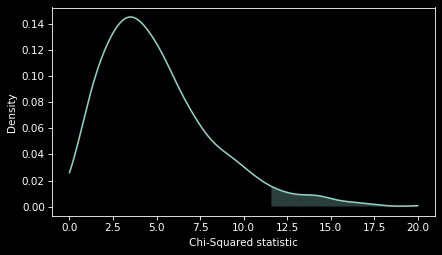

In [51]:
pmf = make_pmf(simulated_chi2, 0, 20)
pmf.plot()
fill_tail(pmf, observed_chi2, "right")
decorate(xlabel="Chi-Squared statistic", ylabel="Density")

Again, the area of the shaded region is the p-value.

In [52]:
compute_p_value(simulated_chi2, observed_chi2)

np.float64(0.04495504495504495)

The p-value using the chi-squared statistic is about 0.04, substantially smaller than what we got using total deviation, 0.13.
If we take the 5% threshold seriously, we would consider this effect statistically significant.
But considering the two tests together, I would say that the results are inconclusive.
I would not rule out the possibility that the die is crooked, but I would not convict the accused cheater.

This example demonstrates an important point: the p-value depends on the choice of test statistic and the model of the null hypothesis, and sometimes these choices determine whether an effect is statistically significant or not.

## Glossary

-   **hypothesis testing**: A set of methods for checking whether an observed effect could plausibly be due to random sampling.

-   **test statistic**: A statistic used in a hypothesis test to quantify the size of an observed effect.

-   **null hypothesis**: A model of a system based on the assumption that an effect observed in a sample does not exist in the population.

-   **permutation**: A way to simulate a null hypothesis by randomly shuffling a dataset.

-   **p-value**: The probability of an effect as big as the observed effect, under a null hypothesis.

-   **statistically significant**: An effect is statistically significant if the p-value is smaller than a chosen threshold, often 5%. In a large dataset, an observed effect can be statistically significant even if it is too small to matter in practice.

## Exercises

### Exercise 9.1

Let's try hypothesis testing with the penguin data from [Chapter 8](section_sampling_distributions).
Instructions for downloading the data are in the notebook for this chapter.

The following cell downloads the data from a repository created by Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

The data was collected as part of the research that led to this paper: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

In [53]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

Here's how we read the data and select the Chinstrap penguins.

In [54]:
penguins = pd.read_csv("penguins_raw.csv").dropna(subset=["Body Mass (g)"])
chinstrap = penguins.query('Species.str.startswith("Chinstrap")')
chinstrap.shape

(68, 17)

And here's how we can extract the weights for male and female penguins in kilograms.

In [55]:
male = chinstrap.query("Sex == 'MALE'")
weights_male = male["Body Mass (g)"] / 1000
weights_male.mean()

np.float64(3.9389705882352937)

In [56]:
female = chinstrap.query("Sex == 'FEMALE'")
weights_female = female["Body Mass (g)"] / 1000
weights_female.mean()

np.float64(3.5272058823529413)

Use `abs_diff_means` and `simulate_groups` to generate a large number of simulated datasets under the null hypothesis that the two groups have the same distribution of weights, and compute the difference in means for each one.
Compare the simulation results to the observed difference and compute a p-value.
Is it plausible that the apparent difference between the groups is due to chance?

In [57]:
# Solution goes here

In [58]:
# Solution goes here

In [59]:
# Solution goes here

In [60]:
# Solution goes here

In [61]:
# Solution goes here

### Exercise 9.2

Using the penguin data from the previous exercise, we can extract the culmen depths and lengths for the female penguins (the culmen is the top ridge of the bill).

In [62]:
data = female["Culmen Depth (mm)"], female["Culmen Length (mm)"]

The correlation between these variables is about 0.26.

In [63]:
observed_corr = abs_correlation(data)
observed_corr

np.float64(0.2563170802728449)

Let's see whether this correlation could happen by chance, even if there is actually no correlation between the measurements.
Use `permute` to generate many permutations of this data and `abs_correlation` to compute the correlation for each one.
Plot the distribution of the correlations under the null hypothesis and compute a p-value for the observed correlation.
How do you interpret the result?

In [64]:
# Solution goes here

In [65]:
# Solution goes here

In [66]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)